# Glacier Meltwater Runoff model
This notebook walks through modelling how meltwater will flow over a glacier and how it will change with different meltwater production.

### Why is surface hydrology important?

### Study motivation and objectives

### Imports

In [3]:
from landlab.components import (
    FlowDirectorD8,
    FlowDirectorMFD,
    FlowDirectorSteepest,
    FlowAccumulator, 
    SinkFillerBarnes,
    DepressionFinderAndRouter
)

from bmi_topography import Topography
from landlab import RasterModelGrid
from landlab.plot.drainage_plot import drainage_plot
from landlab.plot.graph import plot_graph
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import scipy.io
from scipy.ndimage import gaussian_filter

from GlacierSurfaceFlow import GlacierSurfaceFlow
from plotting import flowdir_plot

## Running flow accumulator on channel synthetic glacier

#### Instantiating class and plotting surface elevation

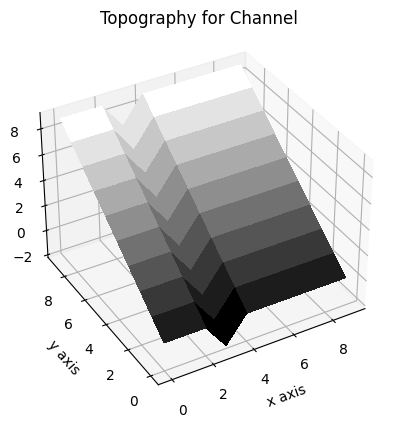

In [4]:
channel = GlacierSurfaceFlow('Channel')
channel.create_flow_acc()
channel.surf_plot()

#### Plotting drainage area

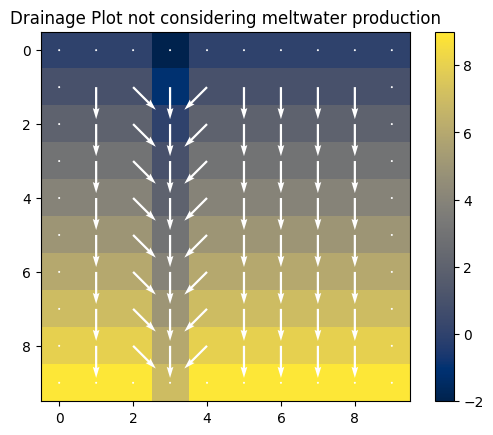

In [7]:
flowdir_plot(channel.grid,1,title='Drainage Plot not considering meltwater production')
plt.show()

#### Incorporating heterogeneous melt production

In [8]:
runoff_rate = np.ones_like(channel.grid.at_node['water__unit_flux_in']) * 10
runoff_rate[(channel.grid.y_of_node==7) & (channel.grid.x_of_node==7)] = 100
channel.grid.at_node['water__unit_flux_in'] = runoff_rate

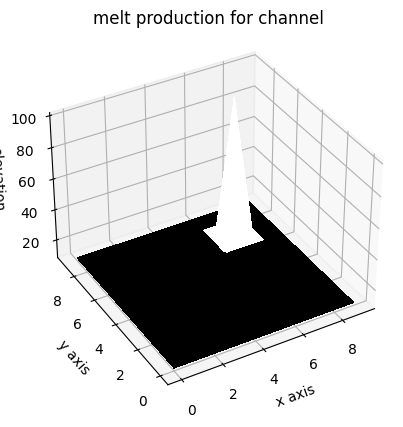

In [9]:
#channel.grid.at_node.keys()
channel.surf_plot(surface='water__unit_flux_in',title='melt production for channel')

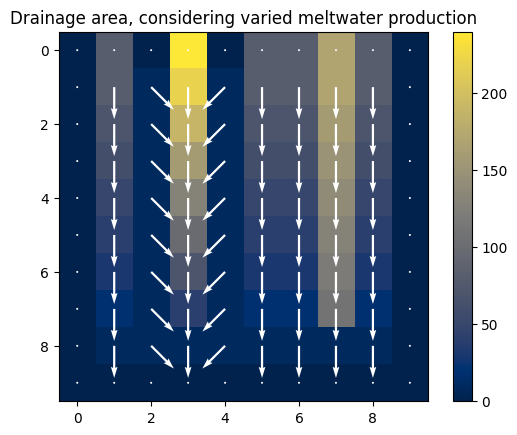

In [10]:
channel.create_flow_acc(runoff_rate = runoff_rate)
flowdir_plot(channel.grid,1,surface='surface_water__discharge',title='Drainage area, considering varied meltwater production')
plt.show()

#### Incorporating firn presence

## Running flow accumulator on Andes DEM

#### Instantiating class and plotting surface elevation

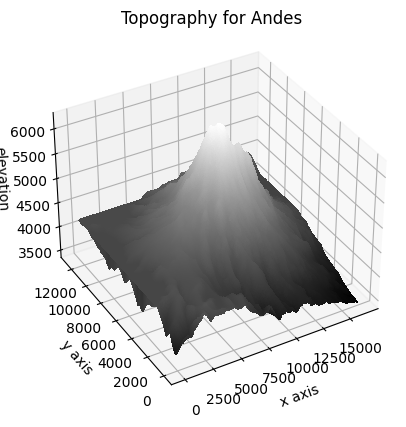

In [11]:
andes = GlacierSurfaceFlow('Andes')
andes.create_flow_acc()
andes.surf_plot()

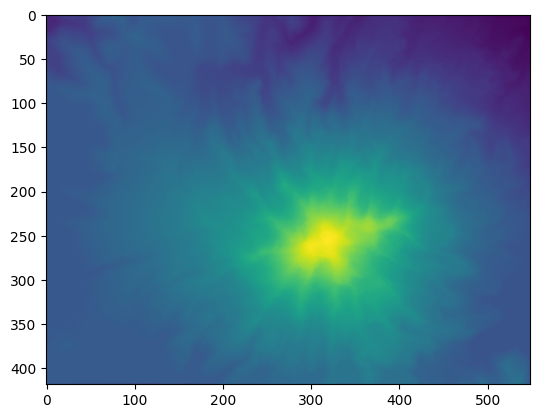

In [14]:
fig,ax=plt.subplots()
ny,nx = andes.grid.number_of_node_rows,andes.grid.number_of_node_columns
ax.imshow(np.reshape(andes.grid.at_node['topographic__elevation'], (ny,nx)))

#### Plotting drainage area

TODO: figure out the best way to plot this

log plot?

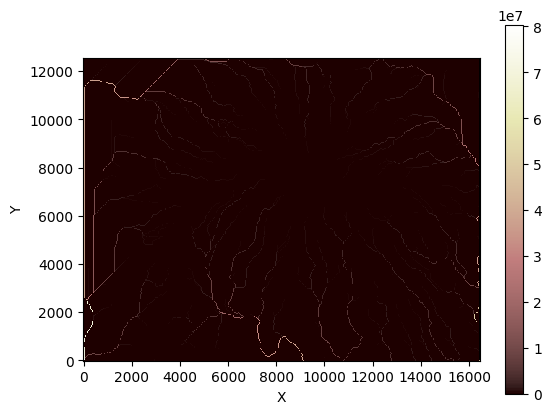

In [12]:
andes.grid.imshow('surface_water__discharge')

#### Incorporating heterogeneous melt production based on climate data

In [16]:
snowmelt = xr.open_dataset('andes_ERA5_data.nc').smlt.mean(dim=['time'])
runoff_rate = andes.grid.add_ones('water__unit_flux_in',at='node',clobber=True)

runoff_rate[(andes.grid.y_of_node >= andes.grid.y_of_node.max()/2) & (andes.grid.x_of_node >= andes.grid.x_of_node.max()/2)] = snowmelt[1][1]
runoff_rate[(andes.grid.y_of_node >= andes.grid.y_of_node.max()/2) & (andes.grid.x_of_node < andes.grid.x_of_node.max()/2)] = snowmelt[1][0]
runoff_rate[(andes.grid.y_of_node < andes.grid.y_of_node.max()/2) & (andes.grid.x_of_node >= andes.grid.x_of_node.max()/2)] = snowmelt[0][1]
runoff_rate[(andes.grid.y_of_node < andes.grid.y_of_node.max()/2) & (andes.grid.x_of_node < andes.grid.x_of_node.max()/2)] = snowmelt[0][0]

runoff_rate = gaussian_filter(andes.grid.at_node['water__unit_flux_in'].reshape(andes.grid.shape),100)
andes.grid.at_node['water__unit_flux_in'] = runoff_rate.reshape(andes.grid.shape)
#np.flip(runoff_rate,axis=1)

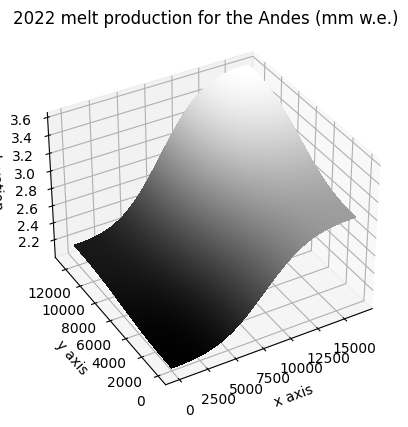

In [17]:
andes.surf_plot(surface='water__unit_flux_in',title = '2022 melt production for the Andes (mm w.e.)')

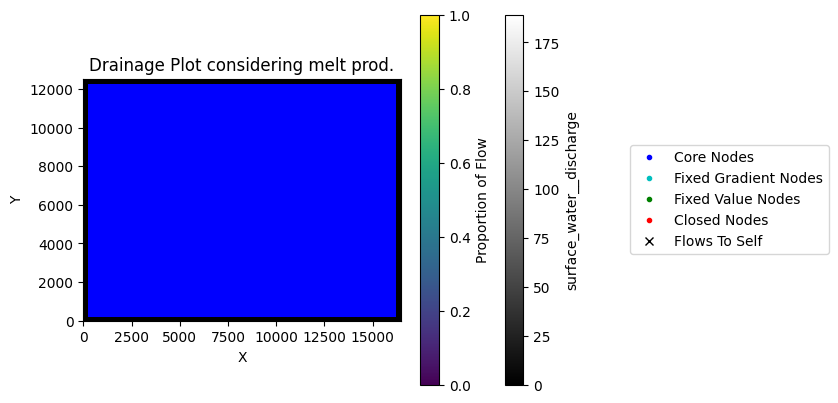

In [18]:
andes.create_flow_acc(runoff_rate = runoff_rate)
drainage_plot(andes.grid,surface='surface_water__discharge',title='Drainage Plot considering melt prod.')
plt.show()

#### Incorporating firn presence

### Conclusions

### Next Steps

### Backup Code

##### Plot synthetic glacier surfaces

In [ ]:
NyeDome = GlacierSurfaceFlow('Nye Dome')
NyeDome.surf_plot()

In [ ]:
channel = GlacierSurfaceFlow('Channel')
channel.surf_plot()

In [ ]:
parabola = GlacierSurfaceFlow('Parabola')
parabola.surf_plot()